In [1]:
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

sim_path = "./sim"
path1 = "../ext_traces/cc.trace"
path2 = "../ext_traces/spice.trace"
path3 = "../ext_traces/tex.trace"

def run_test(case, path):
    if case["I-D"] == "Split":
        command = [
            sim_path,
            f"-bs {case['BS']}",
            f"-is {case['CS']}",
            f"-ds {case['CS']}",
            f"-a {case['Ass']}",
            "-wb" if case["Write"] == "WB" else "-wt",
            "-wa" if case["Alloc"] == "WA" else "-nw",
            path,
        ]
    elif case["I-D"] == "Unified":
        command = [
            sim_path,
            f"-bs {case['BS']}",
            f"-us {case['CS']}",
            f"-a {case['Ass']}",
            "-wb" if case["Write"] == "WB" else "-wt",
            "-wa" if case["Alloc"] == "WA" else "-nw",
            path,
        ]
    else:
        print("failed to handle given inst.")
        return None
    result = subprocess.run(" ".join(command), shell=True, text=True, capture_output=True)
    return result.stdout

def parse_output(output):
    lines = output.split("\n")
    parsed_data = {}
    current = 0
    for line in lines:
        if "INSTRUCTIONS" in line:
            current = 1
        elif "DATA" in line:
            current = 2
        elif "misses:" in line:
            if current == 1:
                parsed_data["I-Misses"] = int(line.split()[-1]) 
            elif current == 2:
                parsed_data["D-Misses"] = int(line.split()[-1]) 
        elif "replace:" in line:
            if current == 1:
                parsed_data["I-repl"] = int(line.split()[-1]) 
            elif current == 2:
                parsed_data["D-repl"] = int(line.split()[-1])
        elif "accesses:" in line:
            if current == 1:
                parsed_data["I-tol"] = int(line.split()[-1])
            elif current == 2:
                parsed_data["D-tol"] = int(line.split()[-1])   
        elif "demand fetch:" in line:
            parsed_data["DF"] = int(line.split()[-1])
        elif "copies back:" in line:
            parsed_data["CB"] = int(line.split()[-1])
        
    parsed_data["I-mr"] = parsed_data["I-Misses"]/((float)(parsed_data["I-tol"]))
    parsed_data["D-mr"] = parsed_data["D-Misses"]/((float)(parsed_data["D-tol"]))
    return parsed_data

# Working Set Characterization
Using your cache simulator, plot the hit rate of the cache as a function of cache size. Start with
a cache size of 4 bytes, and increase the size (each time by a factor of 2) until the hit rate remains
insensitive to cache size. Use **a split cache organization** so that you can separately characterize the
behavior of instruction and data references (i.e., you will have two plots per sample trace–one for
instructions, and one for data). Factor out the eﬀects of conflict misses by *always* using **a fully
associative cache**. Also, always **set the block size to 4 bytes**, use a **write-back** cache, and use the
**write-allocate** policy.

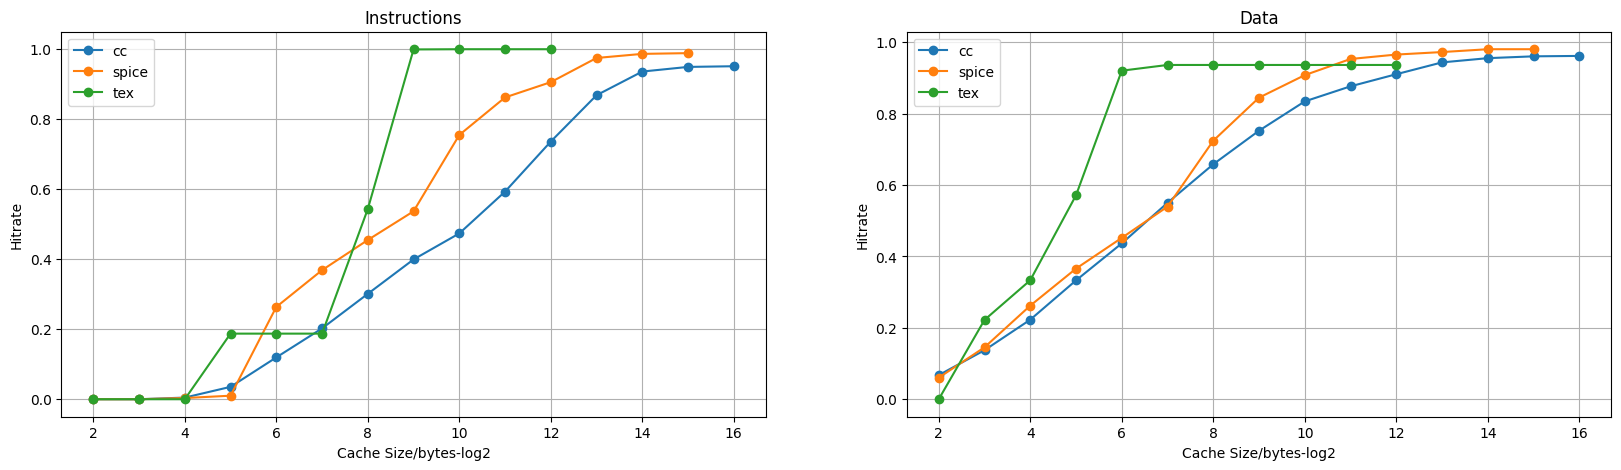

In [2]:
def test2_1(path):
    changeable_case = {"CS": 4, "BS": 4, "I-D": "Split", "Ass": 1, "Write": "WB", "Alloc": "WA"}
    result = parse_output(run_test(changeable_case, path))

    cs = [0]
    hitrate_i = [0]
    hitrate_d = [0]

    cs.append(changeable_case["CS"])
    hitrate_i.append(1-result["I-mr"])
    hitrate_d.append(1-result["D-mr"])

    limit = 0.005
    times = 1
    while not(abs(hitrate_i[-1] - hitrate_i[-2]) < limit and abs(hitrate_d[-1] - hitrate_d[-2]) < limit and times > 10):
        changeable_case["CS"] *= 2
        changeable_case["Ass"] *= 2
        result = parse_output(run_test(changeable_case, path))
        
        cs.append(changeable_case["CS"])
        hitrate_i.append(1-result["I-mr"])
        hitrate_d.append(1-result["D-mr"])
        
        times += 1

    return cs, hitrate_i, hitrate_d

if os.path.exists("./runtime_files/results2_1.npz"):
    data = np.load("./runtime_files/results2_1.npz")
    cs1 = data['cs1']
    hitrate_i1 = data['hitrate_i1']
    hitrate_d1 = data['hitrate_d1']
    cs2 = data['cs2']
    hitrate_i2 = data['hitrate_i2']
    hitrate_d2 = data['hitrate_d2']
    cs3 = data['cs3']
    hitrate_i3 = data['hitrate_i3']
    hitrate_d3 = data['hitrate_d3']
else: 
    cs1, hitrate_i1, hitrate_d1 = test2_1(path1)
    cs2, hitrate_i2, hitrate_d2 = test2_1(path2)
    cs3, hitrate_i3, hitrate_d3 = test2_1(path3)
    cs1 = np.asarray(cs1)
    cs2 = np.asarray(cs2)
    cs3 = np.asarray(cs3)
    np.savez("./runtime_files/results2_1.npz", cs1=cs1, hitrate_i1=hitrate_i1, hitrate_d1=hitrate_d1, cs2=cs2, hitrate_i2=hitrate_i2, hitrate_d2=hitrate_d2, cs3=cs3, hitrate_i3=hitrate_i3, hitrate_d3=hitrate_d3)

cs1, hitrate_i1, hitrate_d1 = cs1[1:], hitrate_i1[1:], hitrate_d1[1:]
cs2, hitrate_i2, hitrate_d2 = cs2[1:], hitrate_i2[1:], hitrate_d2[1:]
cs3, hitrate_i3, hitrate_d3 = cs3[1:], hitrate_i3[1:], hitrate_d3[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(np.log2(cs1), hitrate_i1, label="cc", marker="o")
ax1.plot(np.log2(cs2), hitrate_i2, label="spice", marker="o")
ax1.plot(np.log2(cs3), hitrate_i3, label="tex", marker="o")
ax1.grid(True)
ax1.set_xlabel("Cache Size/bytes-log2")
ax1.set_ylabel("Hitrate")
ax1.set_title("Instructions")
ax1.legend()
ax2.plot(np.log2(cs1), hitrate_d1, label="cc", marker="o")
ax2.plot(np.log2(cs2), hitrate_d2, label="spice", marker="o")
ax2.plot(np.log2(cs3), hitrate_d3, label="tex", marker="o")
ax2.grid(True)
ax2.set_xlabel("Cache Size/bytes-log2")
ax2.set_ylabel("Hitrate")
ax2.set_title("Data")
ax2.legend()
plt.show()



# Impact of Block Size
Set your cache simulator for a **split I- D-cache organization**, each of size **8 K-bytes**. Set the
**associativity to 2**, use a **write-back cache**, and use a **write-allocate** policy. Plot the hit rate of the
cache as a function of block size. Vary the **block size between 4 bytes and 4 K-bytes**, in **powers of
2**. Do this for the three traces, and make a separate plot for instruction and data references.

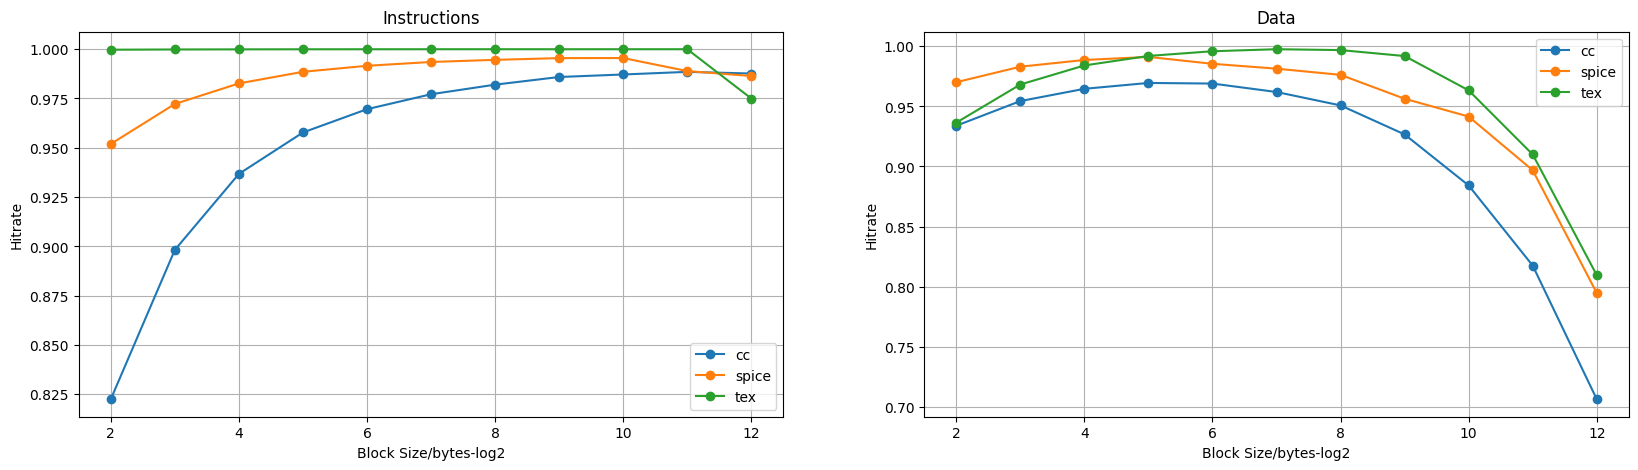

In [3]:
def test2_2(path):
    changeable_case = {"CS": 8192, "BS": 4, "I-D": "Split", "Ass": 2, "Write": "WB", "Alloc": "WA"}
    result = parse_output(run_test(changeable_case, path))

    bs = [0]
    hitrate_i = [0]
    hitrate_d = [0]

    bs.append(changeable_case["BS"])
    hitrate_i.append(1-result["I-mr"])
    hitrate_d.append(1-result["D-mr"])

    # limit = 0.005
    times = 1
    while changeable_case["BS"] < 4096:
        changeable_case["BS"] *= 2
        result = parse_output(run_test(changeable_case, path))
        
        bs.append(changeable_case["BS"])
        hitrate_i.append(1-result["I-mr"])
        hitrate_d.append(1-result["D-mr"])
        
        times += 1

    return bs, hitrate_i, hitrate_d

if os.path.exists("./runtime_files/results2_2.npz"):
    data = np.load("./runtime_files/results2_2.npz")
    bs1 = data['bs1']
    hitrate_i1 = data['hitrate_i1']
    hitrate_d1 = data['hitrate_d1']
    bs2 = data['bs2']
    hitrate_i2 = data['hitrate_i2']
    hitrate_d2 = data['hitrate_d2']
    bs3 = data['bs3']
    hitrate_i3 = data['hitrate_i3']
    hitrate_d3 = data['hitrate_d3']
else: 
    bs1, hitrate_i1, hitrate_d1 = test2_2(path1)
    bs2, hitrate_i2, hitrate_d2 = test2_2(path2)
    bs3, hitrate_i3, hitrate_d3 = test2_2(path3)
    bs1 = np.asarray(bs1)
    bs2 = np.asarray(bs2)
    bs3 = np.asarray(bs3)
    np.savez("./runtime_files/results2_2.npz", bs1=bs1, hitrate_i1=hitrate_i1, hitrate_d1=hitrate_d1, bs2=bs2, hitrate_i2=hitrate_i2, hitrate_d2=hitrate_d2, bs3=bs3, hitrate_i3=hitrate_i3, hitrate_d3=hitrate_d3)

bs1, hitrate_i1, hitrate_d1 = bs1[1:], hitrate_i1[1:], hitrate_d1[1:]
bs2, hitrate_i2, hitrate_d2 = bs2[1:], hitrate_i2[1:], hitrate_d2[1:]
bs3, hitrate_i3, hitrate_d3 = bs3[1:], hitrate_i3[1:], hitrate_d3[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(np.log2(bs1), hitrate_i1, label="cc", marker="o")
ax1.plot(np.log2(bs2), hitrate_i2, label="spice", marker="o")
ax1.plot(np.log2(bs3), hitrate_i3, label="tex", marker="o")
ax1.grid(True)
ax1.set_xlabel("Block Size/bytes-log2")
ax1.set_ylabel("Hitrate")
ax1.set_title("Instructions")
ax1.legend()
ax2.plot(np.log2(bs1), hitrate_d1, label="cc", marker="o")
ax2.plot(np.log2(bs2), hitrate_d2, label="spice", marker="o")
ax2.plot(np.log2(bs3), hitrate_d3, label="tex", marker="o")
ax2.grid(True)
ax2.set_xlabel("Block Size/bytes-log2")
ax2.set_ylabel("Hitrate")
ax2.set_title("Data")
ax2.legend()
plt.show()



# Impact of Associativity
Set your cache simulator for a **split I- D-cache organization**, each of size **8 K-bytes**. Set the **block
size to 128 bytes**, use a **write-back cache**, and use a **write-allocate** policy. Plot the hit rate of the
cache as a function of associativity. Vary the **associativity between 1 and 64**, in powers of 2. Do
this for the three traces, and make a separate plot for instruction and data references.

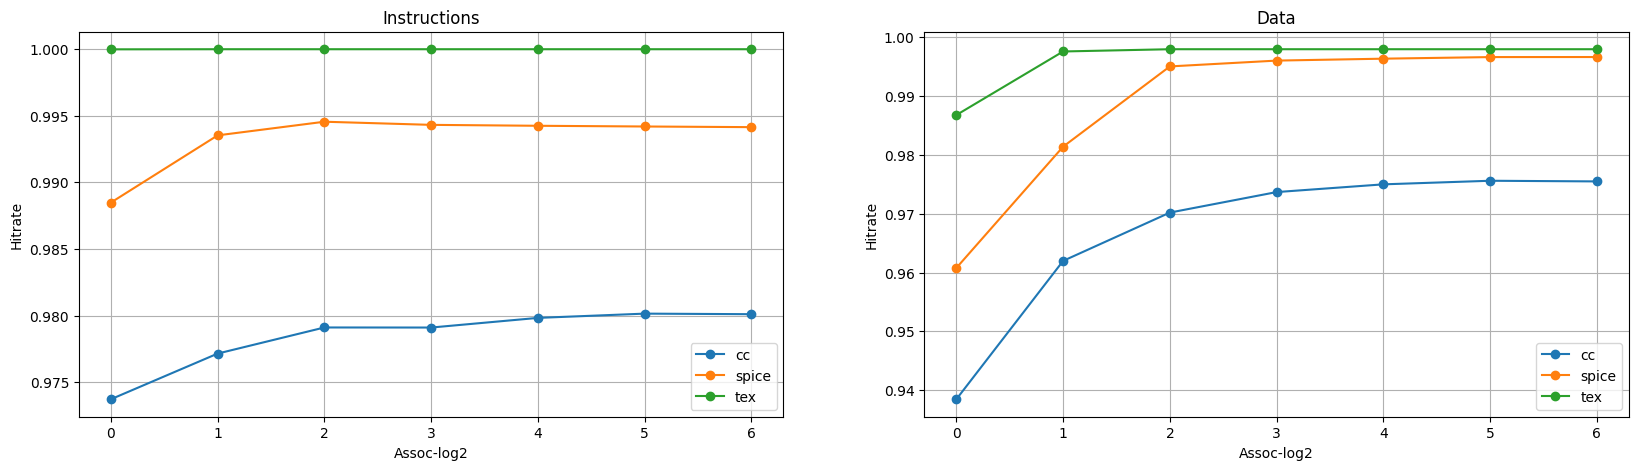

In [4]:
def test2_3(path):
    changeable_case = {"CS": 8192, "BS": 128, "I-D": "Split", "Ass": 1, "Write": "WB", "Alloc": "WA"}
    result = parse_output(run_test(changeable_case, path))

    ass = [0]
    hitrate_i = [0]
    hitrate_d = [0]

    ass.append(changeable_case["Ass"])
    hitrate_i.append(1-result["I-mr"])
    hitrate_d.append(1-result["D-mr"])

    # limit = 0.005
    times = 1
    while changeable_case["Ass"] < 64:
        changeable_case["Ass"] *= 2
        result = parse_output(run_test(changeable_case, path))
        
        ass.append(changeable_case["Ass"])
        hitrate_i.append(1-result["I-mr"])
        hitrate_d.append(1-result["D-mr"])
        
        times += 1

    return ass, hitrate_i, hitrate_d

if os.path.exists("./runtime_files/results2_3.npz"):
    data = np.load("./runtime_files/results2_3.npz")
    ass1 = data['ass1']
    hitrate_i1 = data['hitrate_i1']
    hitrate_d1 = data['hitrate_d1']
    ass2 = data['ass2']
    hitrate_i2 = data['hitrate_i2']
    hitrate_d2 = data['hitrate_d2']
    ass3 = data['ass3']
    hitrate_i3 = data['hitrate_i3']
    hitrate_d3 = data['hitrate_d3']
else: 
    ass1, hitrate_i1, hitrate_d1 = test2_3(path1)
    ass2, hitrate_i2, hitrate_d2 = test2_3(path2)
    ass3, hitrate_i3, hitrate_d3 = test2_3(path3)
    ass1 = np.asarray(ass1)
    ass2 = np.asarray(ass2)
    ass3 = np.asarray(ass3)
    np.savez("./runtime_files/results2_3.npz", ass1=ass1, hitrate_i1=hitrate_i1, hitrate_d1=hitrate_d1, ass2=ass2, hitrate_i2=hitrate_i2, hitrate_d2=hitrate_d2, ass3=ass3, hitrate_i3=hitrate_i3, hitrate_d3=hitrate_d3)

ass1, hitrate_i1, hitrate_d1 = ass1[1:], hitrate_i1[1:], hitrate_d1[1:]
ass2, hitrate_i2, hitrate_d2 = ass2[1:], hitrate_i2[1:], hitrate_d2[1:]
ass3, hitrate_i3, hitrate_d3 = ass3[1:], hitrate_i3[1:], hitrate_d3[1:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(np.log2(ass1), hitrate_i1, label="cc", marker="o")
ax1.plot(np.log2(ass2), hitrate_i2, label="spice", marker="o")
ax1.plot(np.log2(ass3), hitrate_i3, label="tex", marker="o")
ax1.grid(True)
ax1.set_xlabel("Assoc-log2")
ax1.set_ylabel("Hitrate")
ax1.set_title("Instructions")
ax1.legend()
ax2.plot(np.log2(ass1), hitrate_d1, label="cc", marker="o")
ax2.plot(np.log2(ass2), hitrate_d2, label="spice", marker="o")
ax2.plot(np.log2(ass3), hitrate_d3, label="tex", marker="o")
ax2.grid(True)
ax2.set_xlabel("Assoc-log2")
ax2.set_ylabel("Hitrate")
ax2.set_title("Data")
ax2.legend()
plt.show()



# Memory Bandwidth
Using your cache simulator, compare the **total memory traﬃc** generated by a **write-through** versus
**write-back** cache. Use a **split I- D-cache** organization. Simulate a couple of reasonable cache
sizes (such as **8 K-bytes and 16 K-bytes**), reasonable block sizes (such as **64 and 128 bytes**), and
reasonable associativities (such as **2 and 4**). For now, use a **write-no-allocate** policy. Run 4 or 5
diﬀerent simulations total.

In [5]:
def test2_4(path):
    changeable_case = {"CS": 8192, "BS": 16, "I-D": "Split", "Ass": 1, "Write": "WT", "Alloc": "WNA"}
    
    cs_range = [4096, 8192, 16384, 32768]
    bs_range = [16, 32, 64, 128]
    ass_range = [1, 2, 4, 8]
    write_range = ["WB", "WT"]
    
    cs_tol = []
    bs_tol = []
    ass_tol = []
    write_tol = []
    DF = []
    CB = []
    
    for cs_i in cs_range:
        changeable_case["CS"] = cs_i
        for bs_i in bs_range:
            changeable_case["BS"] = bs_i
            for ass_i in ass_range:
                changeable_case["Ass"] = ass_i
                for write_i in write_range:
                    changeable_case["Write"] = write_i
                    
                    result = parse_output(run_test(changeable_case, path))
                    DF.append(result["DF"])
                    CB.append(result["CB"])
                    
                    cs_tol.append(changeable_case["CS"])
                    bs_tol.append(changeable_case["BS"])
                    ass_tol.append(changeable_case["Ass"])
                    write_tol.append(changeable_case["Write"])

    return cs_tol, bs_tol, ass_tol, write_tol, DF, CB

if os.path.exists("./runtime_files/results2_4.npz"):
    data = np.load("./runtime_files/results2_4.npz")
    cs_tol1 = data['cs_tol1']
    bs_tol1 = data['bs_tol1']
    ass_tol1 = data['ass_tol1']
    write_tol1 = data['write_tol1']
    DF1 = data['DF1']
    CB1 = data['CB1']
    cs_tol2 = data['cs_tol2']
    bs_tol2 = data['bs_tol2']
    ass_tol2 = data['ass_tol2']
    write_tol2 = data['write_tol2']
    DF2 = data['DF2']
    CB2 = data['CB2']
    cs_tol3 = data['cs_tol3']
    bs_tol3 = data['bs_tol3']
    ass_tol3 = data['ass_tol3']
    write_tol3 = data['write_tol3']
    DF3 = data['DF3']
    CB3 = data['CB3']
else: 
    cs_tol1, bs_tol1, ass_tol1, write_tol1, DF1, CB1 = test2_4(path1)
    cs_tol2, bs_tol2, ass_tol2, write_tol2, DF2, CB2 = test2_4(path2)
    cs_tol3, bs_tol3, ass_tol3, write_tol3, DF3, CB3 = test2_4(path3)
    np.savez("./runtime_files/results2_4.npz", cs_tol1=cs_tol1, bs_tol1=bs_tol1, ass_tol1=ass_tol1, write_tol1=write_tol1, DF1=DF1, CB1=CB1, \
                                               cs_tol2=cs_tol2, bs_tol2=bs_tol2, ass_tol2=ass_tol2, write_tol2=write_tol2, DF2=DF2, CB2=CB2, \
                                               cs_tol3=cs_tol3, bs_tol3=bs_tol3, ass_tol3=ass_tol3, write_tol3=write_tol3, DF3=DF3, CB3=CB3)
    
df1 = pd.DataFrame({"CS":cs_tol1, "BS":bs_tol1, "Ass":ass_tol1, "Write":write_tol1, "DF":DF1, "CB":CB1})
df2 = pd.DataFrame({"CS":cs_tol2, "BS":bs_tol2, "Ass":ass_tol2, "Write":write_tol2, "DF":DF2, "CB":CB2})
df3 = pd.DataFrame({"CS":cs_tol3, "BS":bs_tol3, "Ass":ass_tol3, "Write":write_tol3, "DF":DF3, "CB":CB3})
print(df1.loc[(df1["BS"]==16)&(df1["Ass"]==2)&(df1["Write"]=="WT")])

       CS  BS  Ass Write      DF     CB
3    4096  16    2    WT  345744  83030
35   8192  16    2    WT  216048  83030
67  16384  16    2    WT  116364  83030
99  32768  16    2    WT   71640  83030


## Cache size

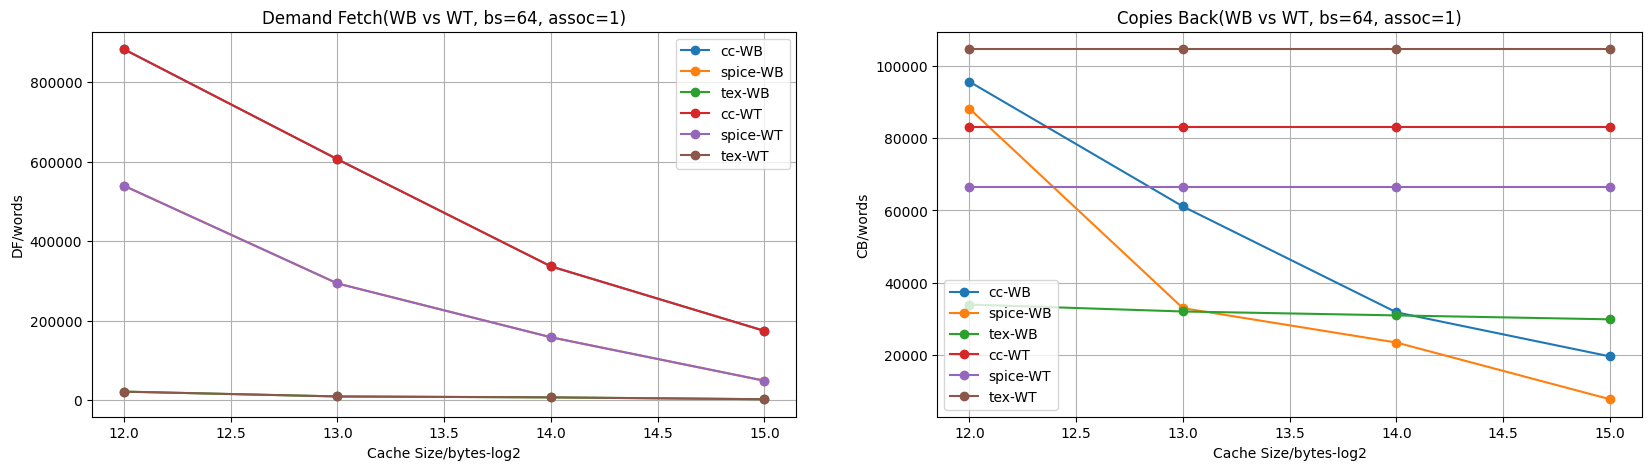

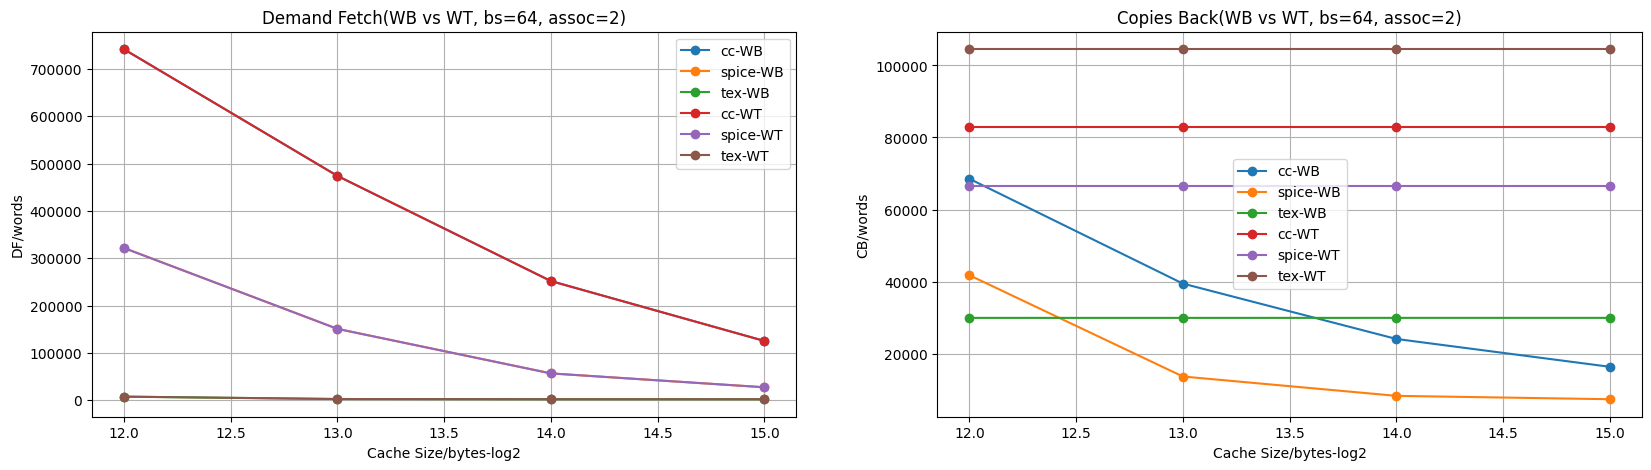

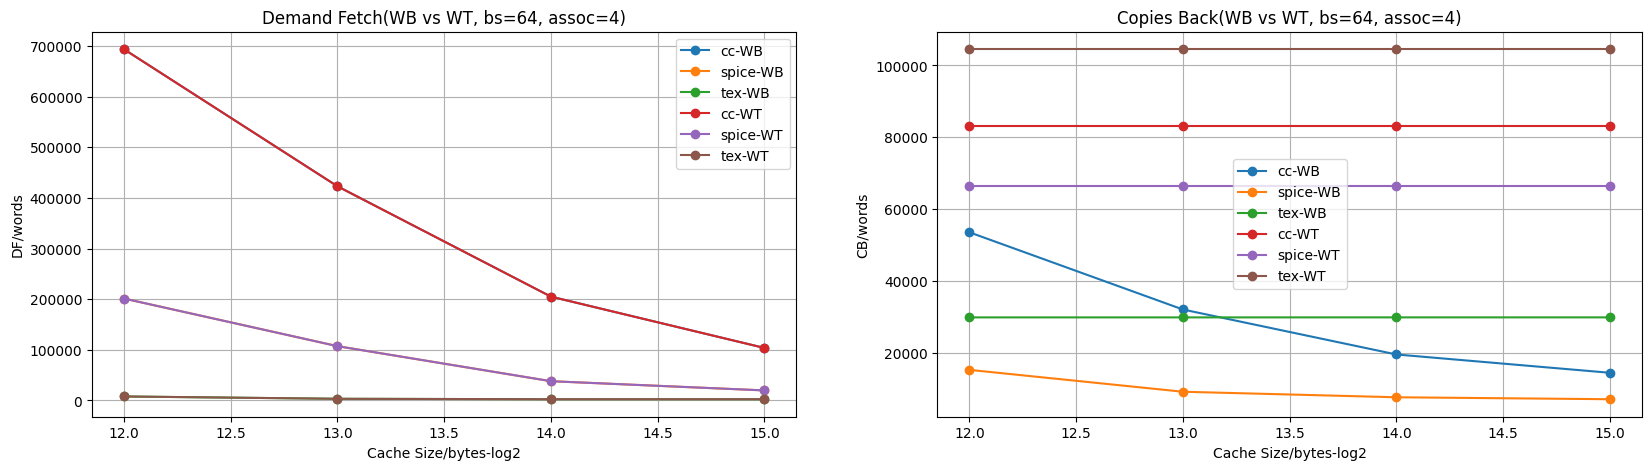

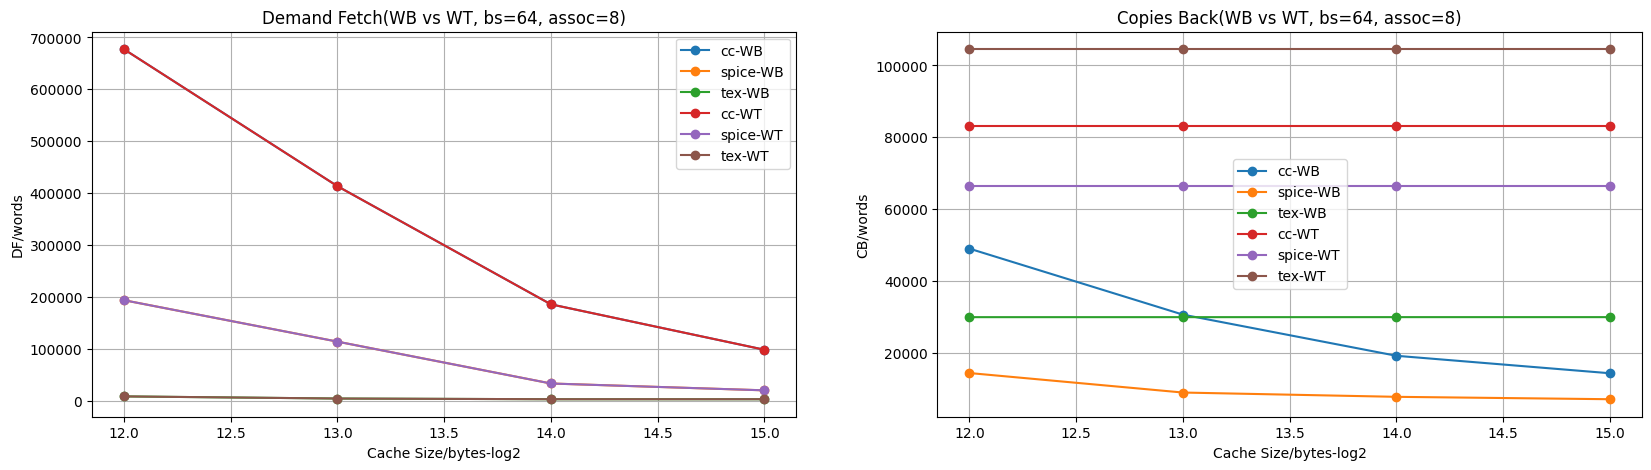

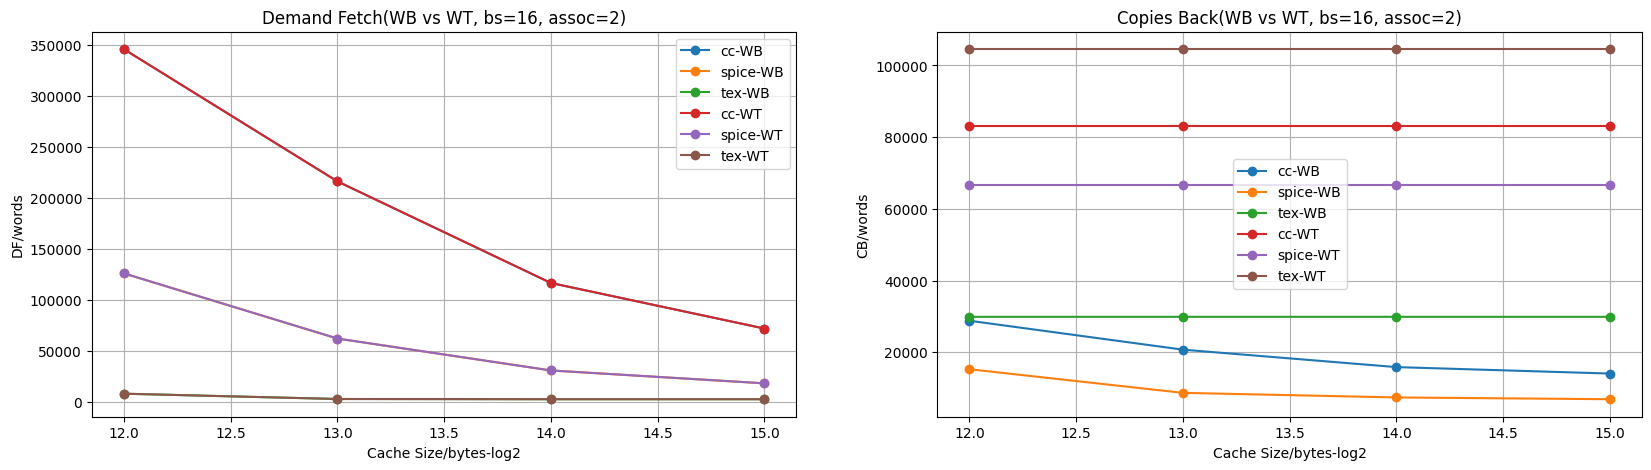

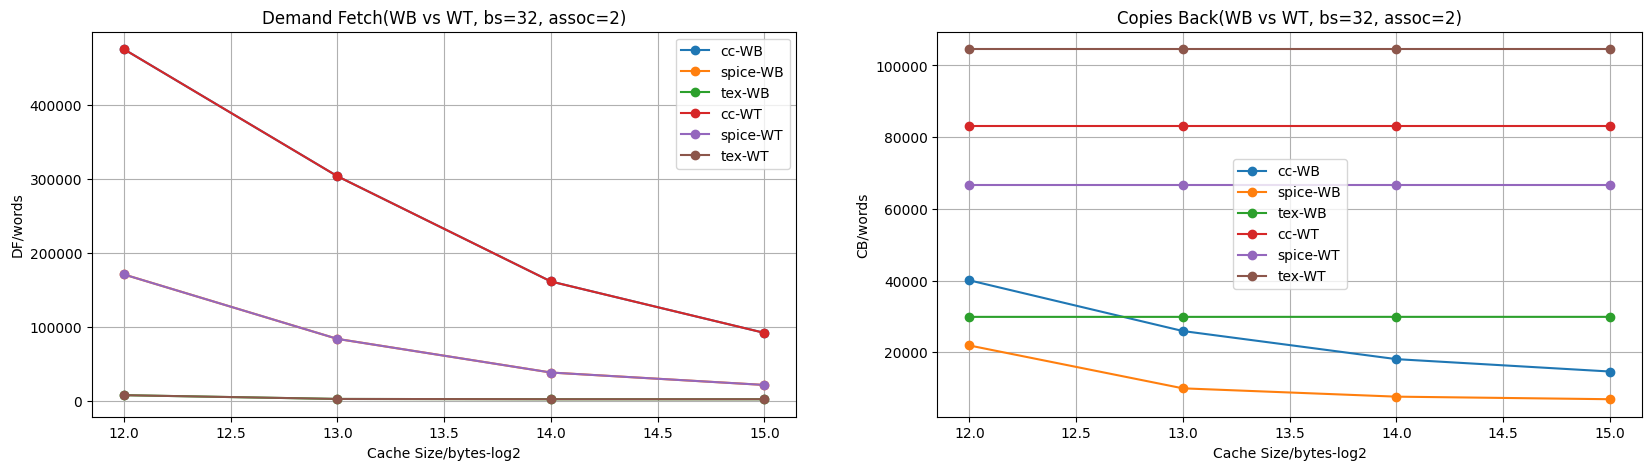

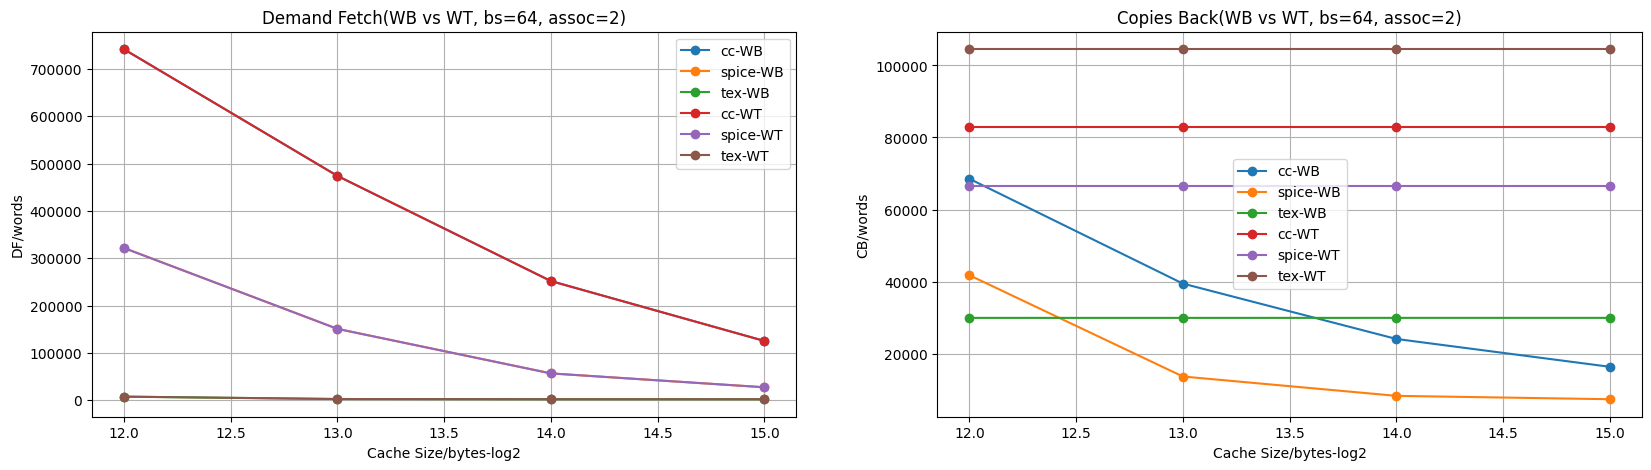

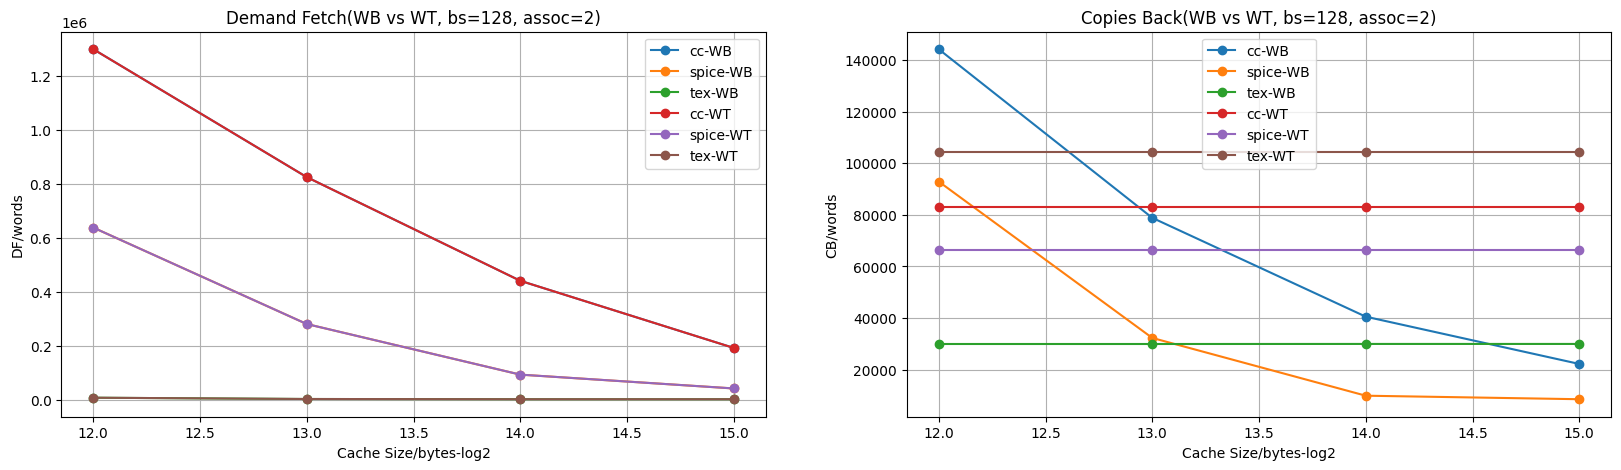

In [6]:
def draw_24_cs(bs, ass, df1, df2, df3):
    df1_select_wb = df1.loc[(df1["BS"]==bs)&(df1["Ass"]==ass)&(df1["Write"]=="WB")]
    df2_select_wb = df2.loc[(df2["BS"]==bs)&(df2["Ass"]==ass)&(df2["Write"]=="WB")]
    df3_select_wb = df3.loc[(df3["BS"]==bs)&(df3["Ass"]==ass)&(df3["Write"]=="WB")]
    df1_select_wt = df1.loc[(df1["BS"]==bs)&(df1["Ass"]==ass)&(df1["Write"]=="WT")]
    df2_select_wt = df2.loc[(df2["BS"]==bs)&(df2["Ass"]==ass)&(df2["Write"]=="WT")]
    df3_select_wt = df3.loc[(df3["BS"]==bs)&(df3["Ass"]==ass)&(df3["Write"]=="WT")]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(np.log2(df1_select_wb["CS"]), df1_select_wb["DF"], label="cc-WB", marker="o")
    ax1.plot(np.log2(df2_select_wb["CS"]), df2_select_wb["DF"], label="spice-WB", marker="o")
    ax1.plot(np.log2(df3_select_wb["CS"]), df3_select_wb["DF"], label="tex-WB", marker="o")
    ax1.plot(np.log2(df1_select_wt["CS"]), df1_select_wt["DF"], label="cc-WT", marker="o")
    ax1.plot(np.log2(df2_select_wt["CS"]), df2_select_wt["DF"], label="spice-WT", marker="o")
    ax1.plot(np.log2(df3_select_wt["CS"]), df3_select_wt["DF"], label="tex-WT", marker="o")
    ax1.grid(True)
    ax1.set_xlabel("Cache Size/bytes-log2")
    ax1.set_ylabel("DF/words")
    ax1.set_title(f"Demand Fetch(WB vs WT, bs={bs}, assoc={ass})")
    ax1.legend()
    ax2.plot(np.log2(df1_select_wb["CS"]), df1_select_wb["CB"], label="cc-WB", marker="o")
    ax2.plot(np.log2(df2_select_wb["CS"]), df2_select_wb["CB"], label="spice-WB", marker="o")
    ax2.plot(np.log2(df3_select_wb["CS"]), df3_select_wb["CB"], label="tex-WB", marker="o")
    ax2.plot(np.log2(df1_select_wt["CS"]), df1_select_wt["CB"], label="cc-WT", marker="o")
    ax2.plot(np.log2(df2_select_wt["CS"]), df2_select_wt["CB"], label="spice-WT", marker="o")
    ax2.plot(np.log2(df3_select_wt["CS"]), df3_select_wt["CB"], label="tex-WT", marker="o")
    ax2.grid(True)
    ax2.set_xlabel("Cache Size/bytes-log2")
    ax2.set_ylabel("CB/words")
    ax2.set_title(f"Copies Back(WB vs WT, bs={bs}, assoc={ass})")
    ax2.legend()
    plt.show()
    
draw_24_cs(bs=64, ass=1, df1=df1, df2=df2, df3=df3)
draw_24_cs(bs=64, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_cs(bs=64, ass=4, df1=df1, df2=df2, df3=df3)
draw_24_cs(bs=64, ass=8, df1=df1, df2=df2, df3=df3)
draw_24_cs(bs=16, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_cs(bs=32, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_cs(bs=64, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_cs(bs=128, ass=2, df1=df1, df2=df2, df3=df3)

## Block size

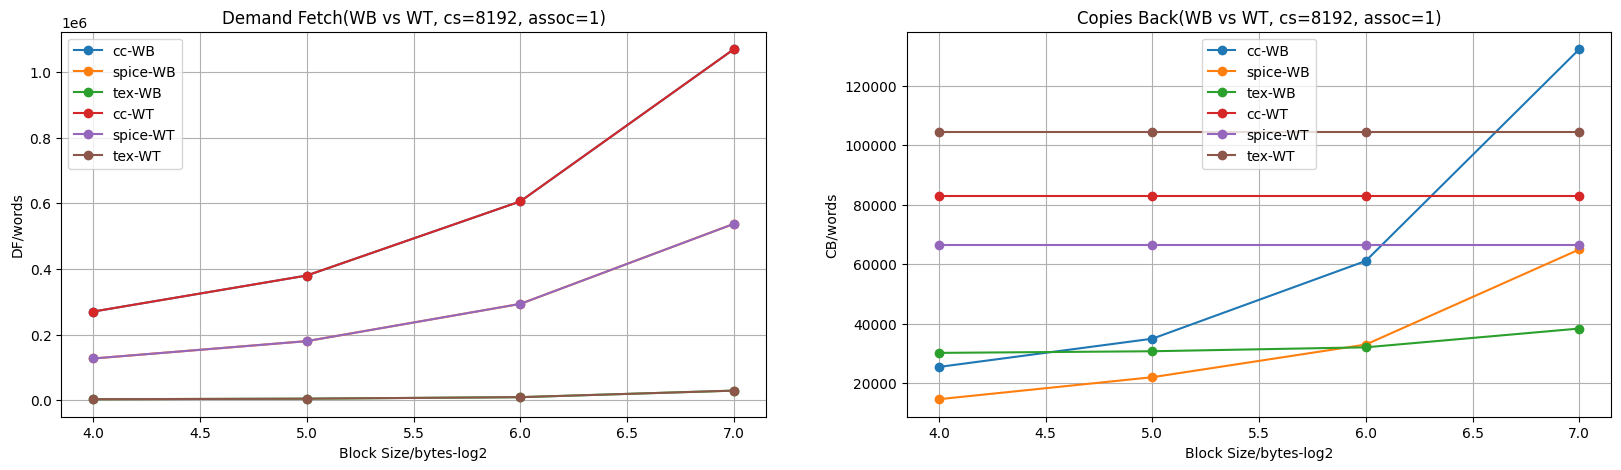

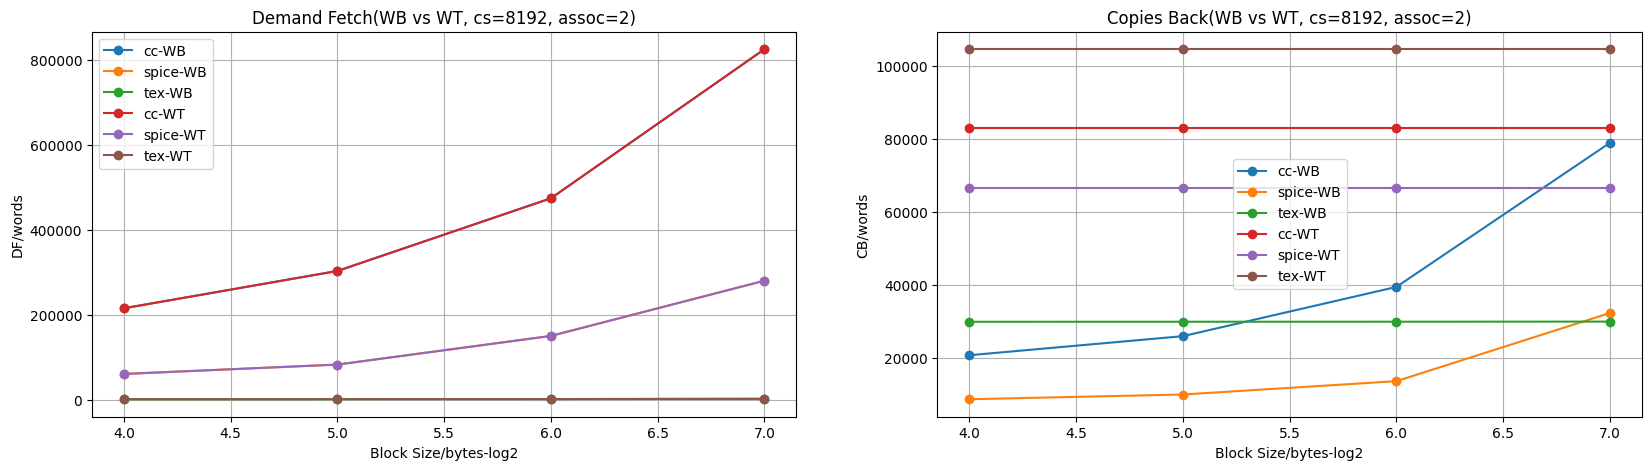

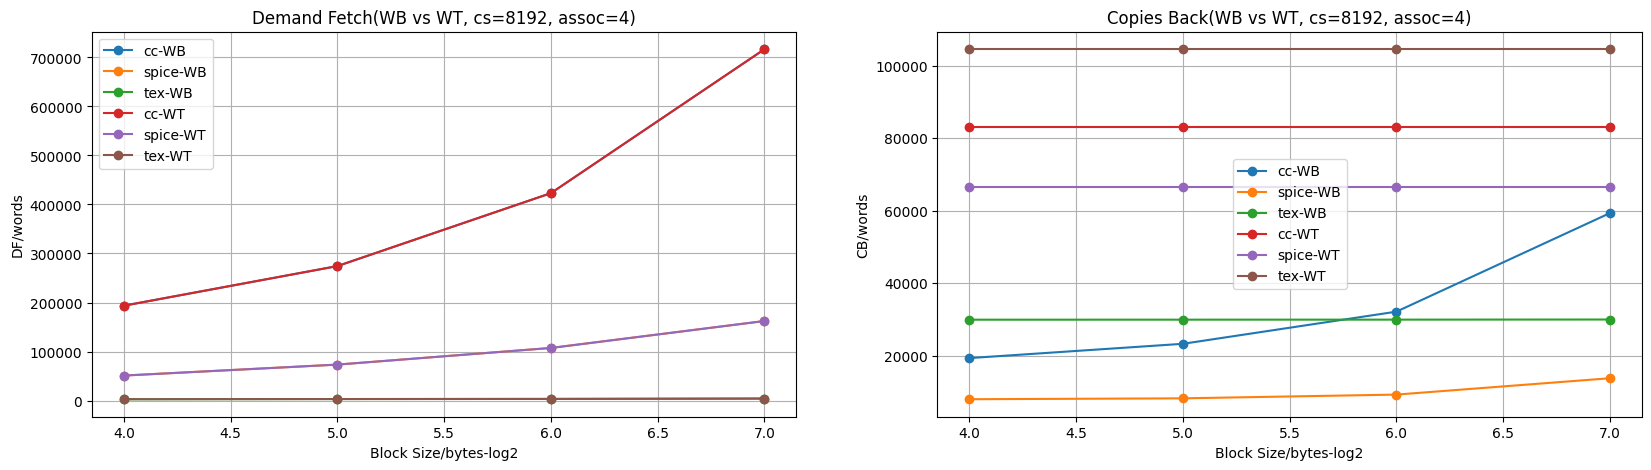

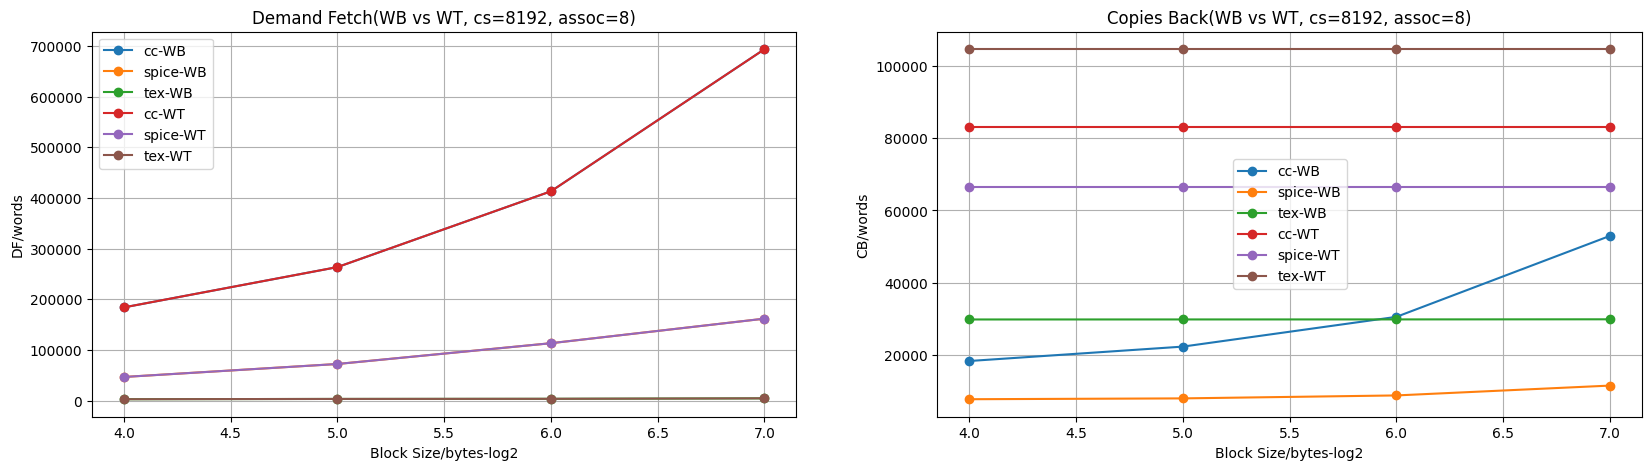

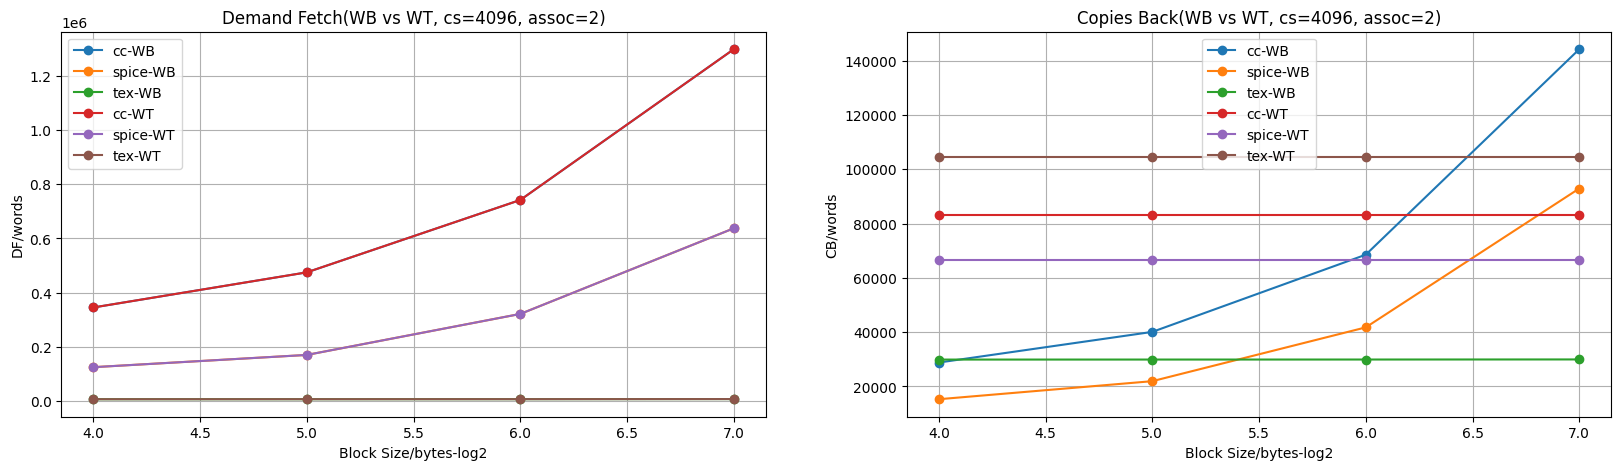

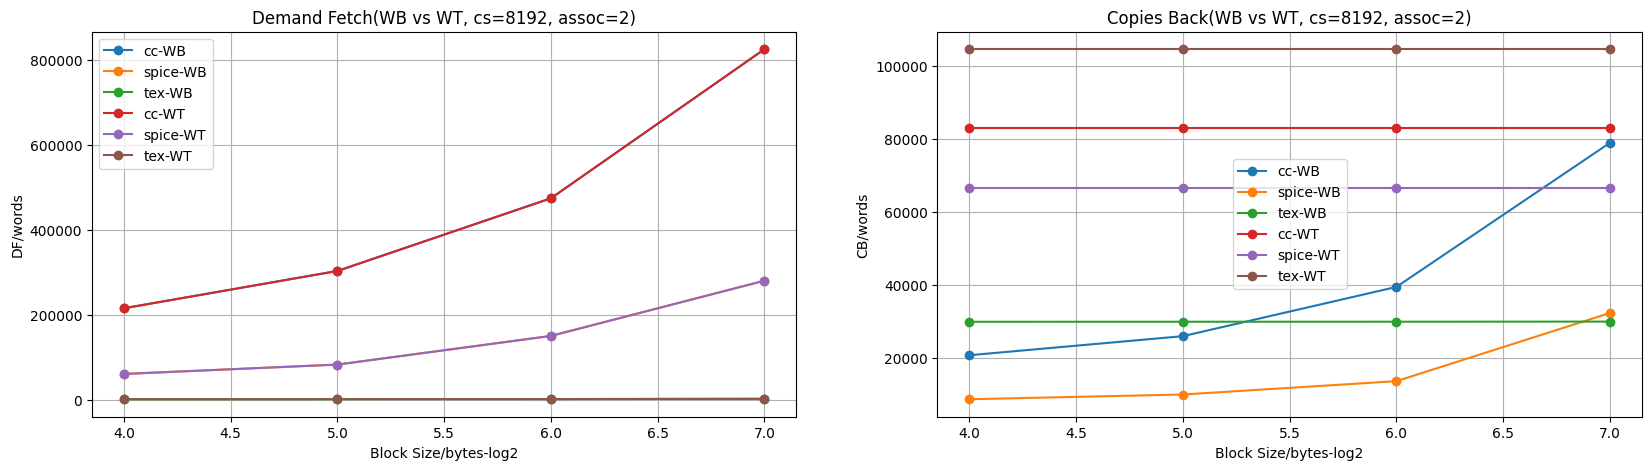

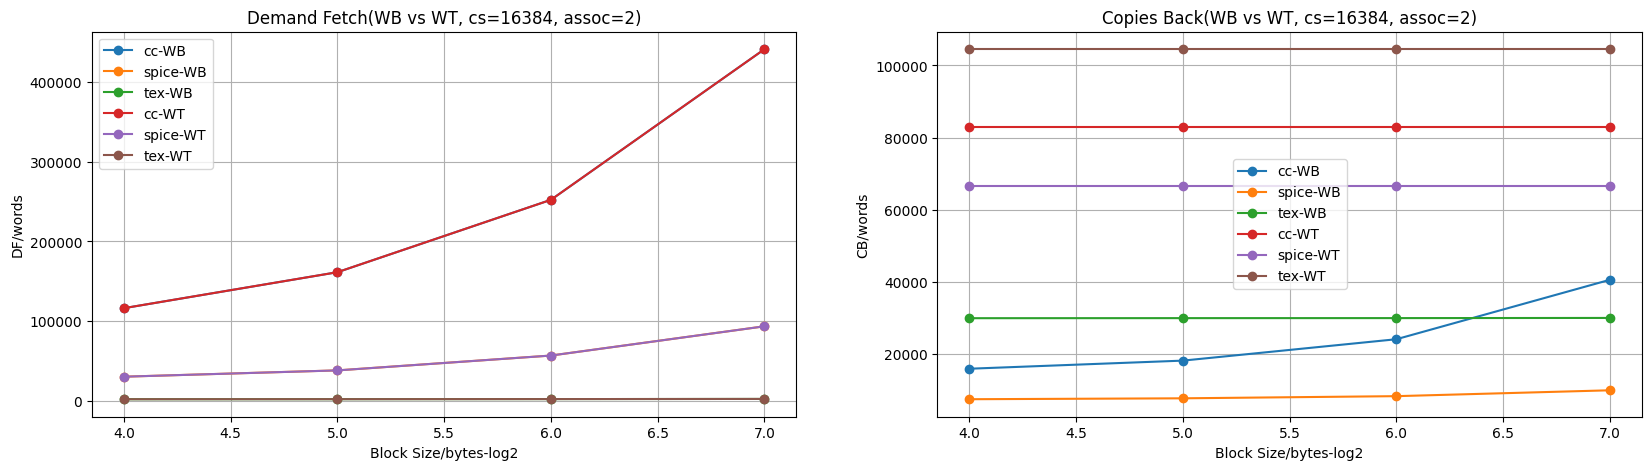

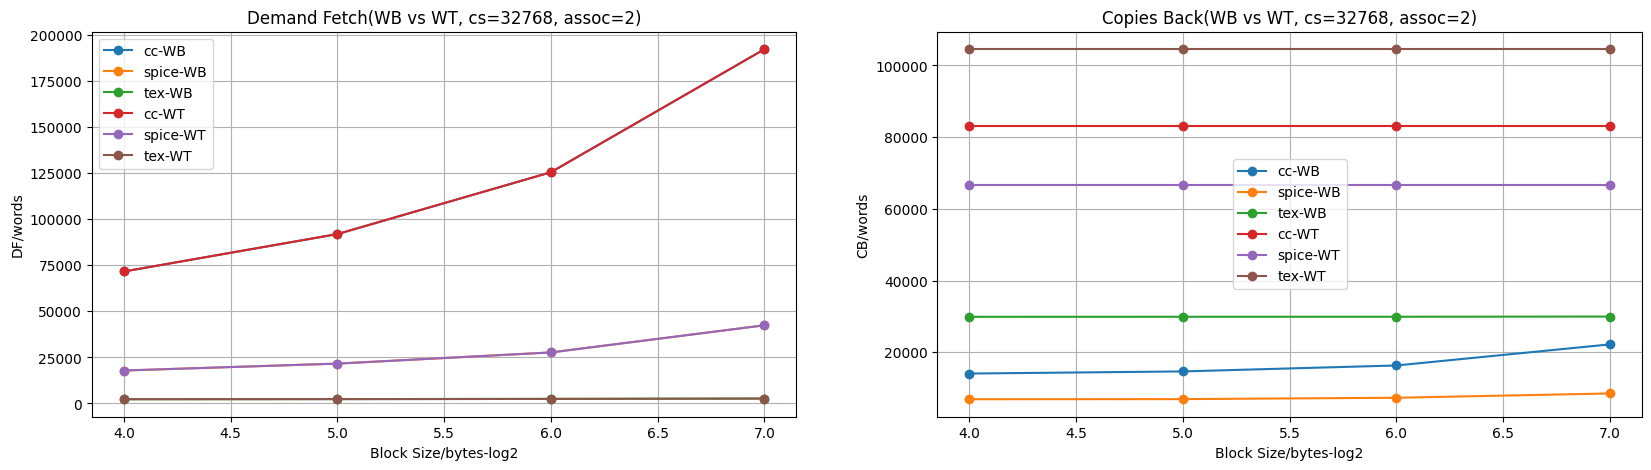

In [7]:
def draw_24_bs(cs, ass, df1, df2, df3):
    df1_select_wb = df1.loc[(df1["CS"]==cs)&(df1["Ass"]==ass)&(df1["Write"]=="WB")]
    df2_select_wb = df2.loc[(df2["CS"]==cs)&(df2["Ass"]==ass)&(df2["Write"]=="WB")]
    df3_select_wb = df3.loc[(df3["CS"]==cs)&(df3["Ass"]==ass)&(df3["Write"]=="WB")]
    df1_select_wt = df1.loc[(df1["CS"]==cs)&(df1["Ass"]==ass)&(df1["Write"]=="WT")]
    df2_select_wt = df2.loc[(df2["CS"]==cs)&(df2["Ass"]==ass)&(df2["Write"]=="WT")]
    df3_select_wt = df3.loc[(df3["CS"]==cs)&(df3["Ass"]==ass)&(df3["Write"]=="WT")]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(np.log2(df1_select_wb["BS"]), df1_select_wb["DF"], label="cc-WB", marker="o")
    ax1.plot(np.log2(df2_select_wb["BS"]), df2_select_wb["DF"], label="spice-WB", marker="o")
    ax1.plot(np.log2(df3_select_wb["BS"]), df3_select_wb["DF"], label="tex-WB", marker="o")
    ax1.plot(np.log2(df1_select_wt["BS"]), df1_select_wt["DF"], label="cc-WT", marker="o")
    ax1.plot(np.log2(df2_select_wt["BS"]), df2_select_wt["DF"], label="spice-WT", marker="o")
    ax1.plot(np.log2(df3_select_wt["BS"]), df3_select_wt["DF"], label="tex-WT", marker="o")
    ax1.grid(True)
    ax1.set_xlabel("Block Size/bytes-log2")
    ax1.set_ylabel("DF/words")
    ax1.set_title(f"Demand Fetch(WB vs WT, cs={cs}, assoc={ass})")
    ax1.legend()
    ax2.plot(np.log2(df1_select_wb["BS"]), df1_select_wb["CB"], label="cc-WB", marker="o")
    ax2.plot(np.log2(df2_select_wb["BS"]), df2_select_wb["CB"], label="spice-WB", marker="o")
    ax2.plot(np.log2(df3_select_wb["BS"]), df3_select_wb["CB"], label="tex-WB", marker="o")
    ax2.plot(np.log2(df1_select_wt["BS"]), df1_select_wt["CB"], label="cc-WT", marker="o")
    ax2.plot(np.log2(df2_select_wt["BS"]), df2_select_wt["CB"], label="spice-WT", marker="o")
    ax2.plot(np.log2(df3_select_wt["BS"]), df3_select_wt["CB"], label="tex-WT", marker="o")
    ax2.grid(True)
    ax2.set_xlabel("Block Size/bytes-log2")
    ax2.set_ylabel("CB/words")
    ax2.set_title(f"Copies Back(WB vs WT, cs={cs}, assoc={ass})")
    ax2.legend()
    plt.show()
    
draw_24_bs(cs=8192, ass=1, df1=df1, df2=df2, df3=df3)
draw_24_bs(cs=8192, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_bs(cs=8192, ass=4, df1=df1, df2=df2, df3=df3)
draw_24_bs(cs=8192, ass=8, df1=df1, df2=df2, df3=df3)
draw_24_bs(cs=4096, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_bs(cs=8192, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_bs(cs=16384, ass=2, df1=df1, df2=df2, df3=df3)
draw_24_bs(cs=32768, ass=2, df1=df1, df2=df2, df3=df3)

## Associativity

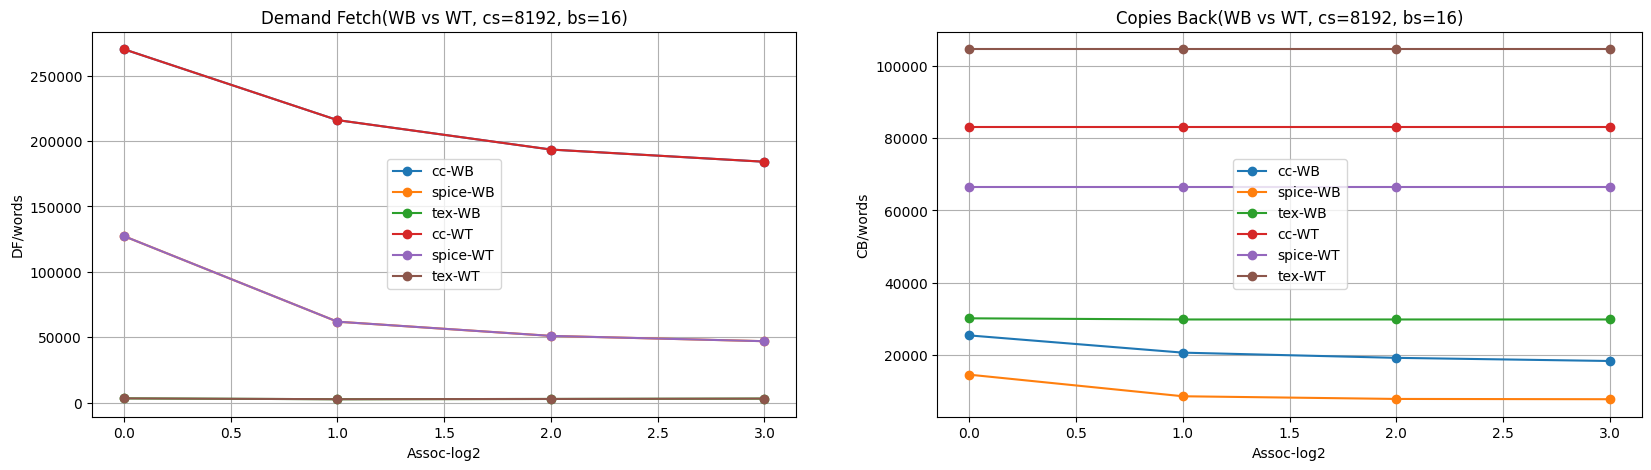

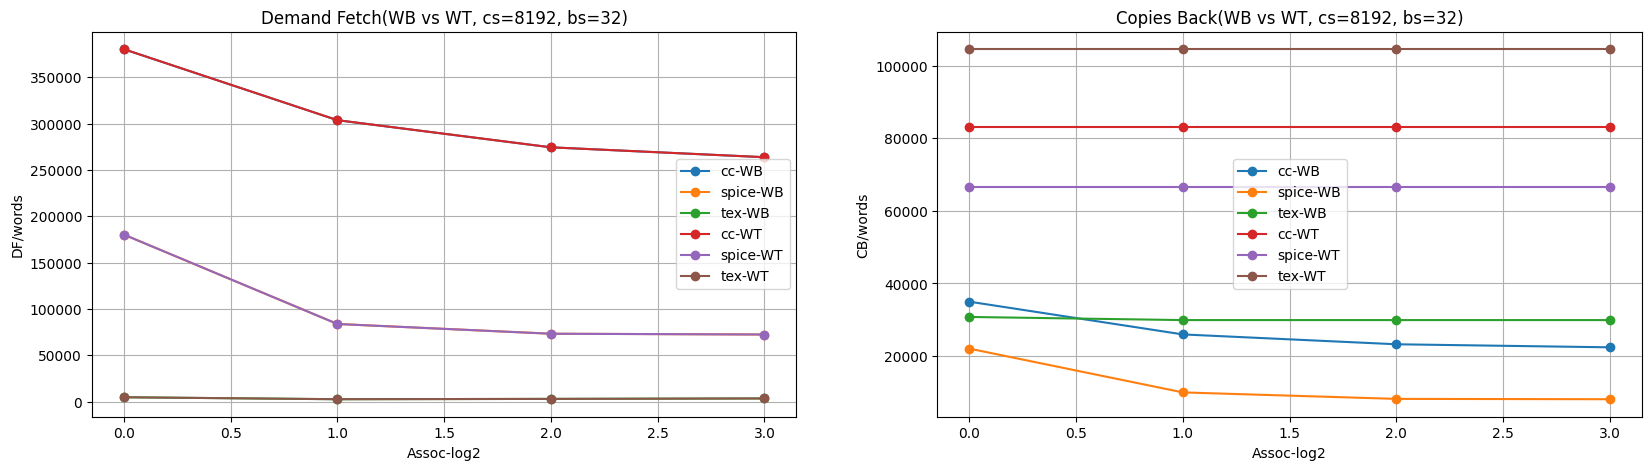

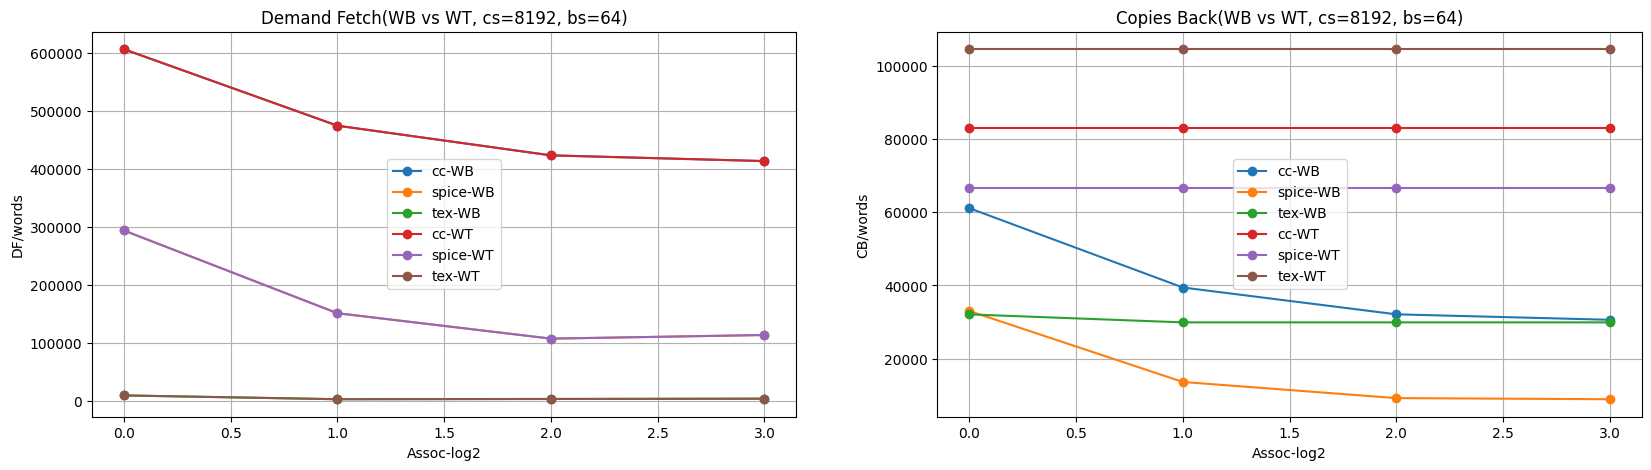

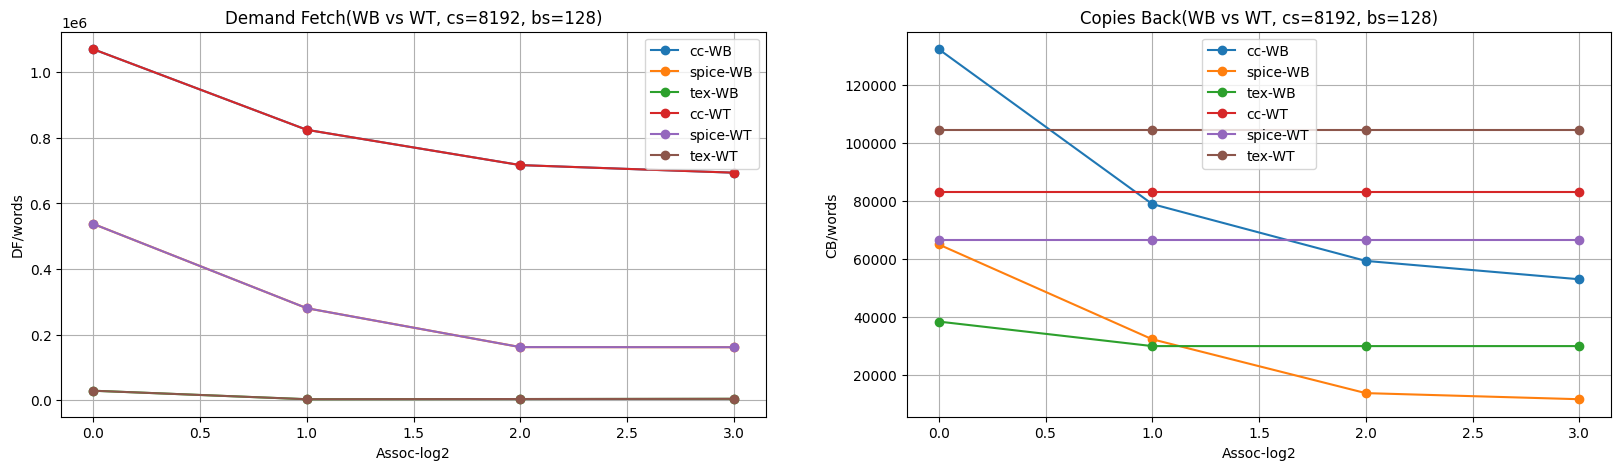

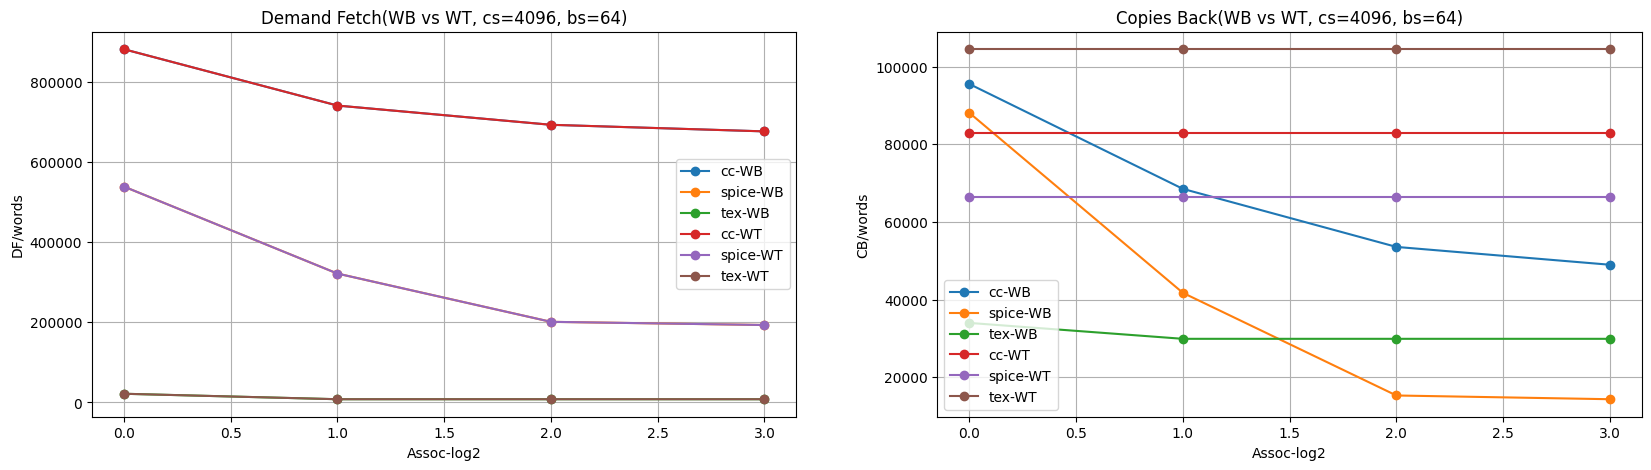

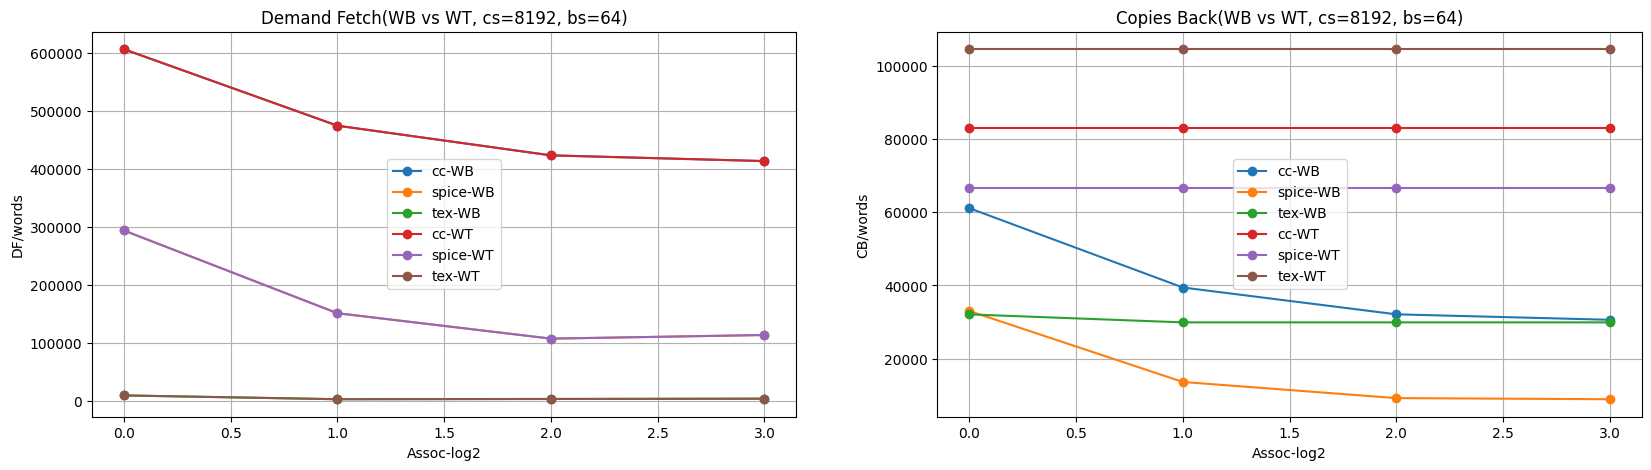

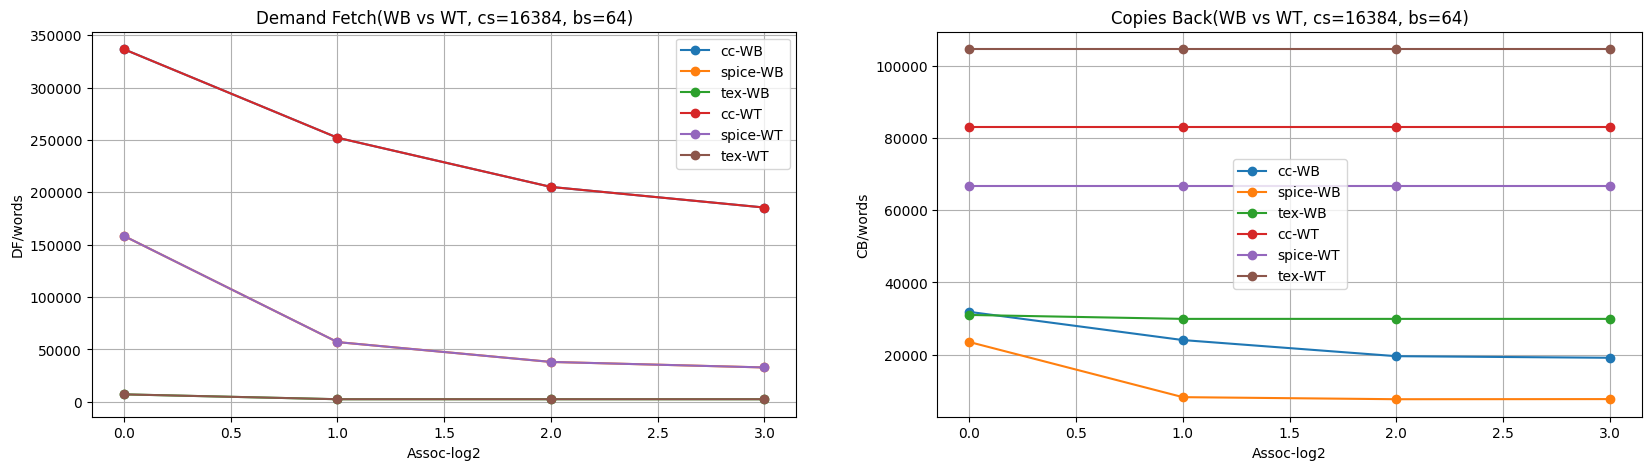

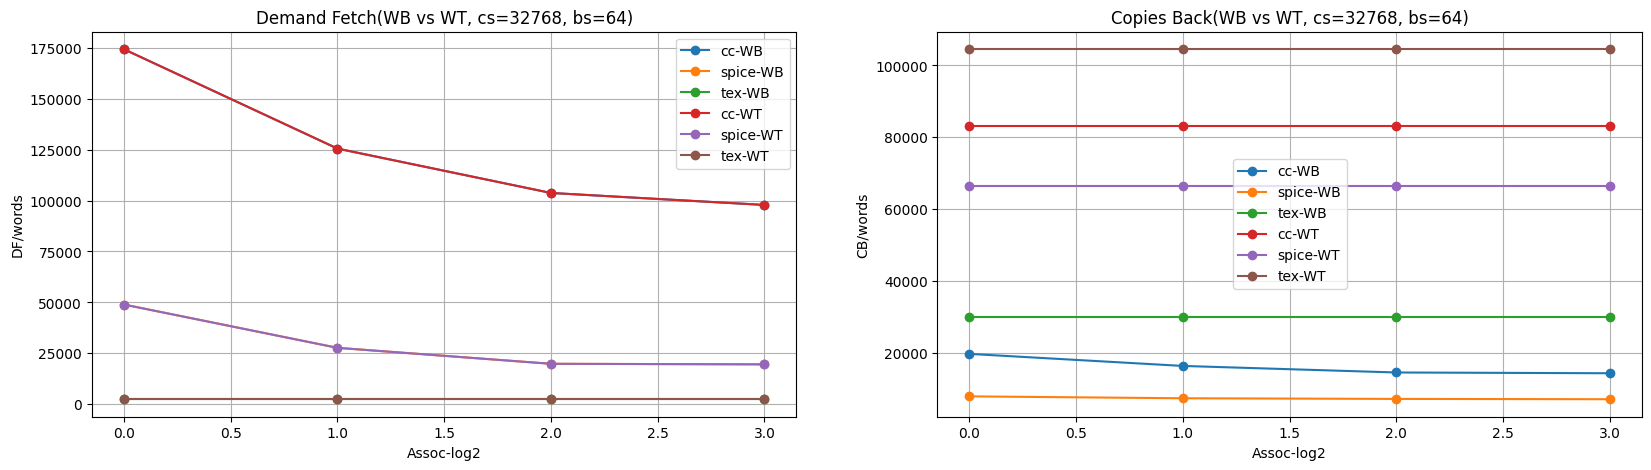

In [8]:
def draw_24_ass(cs, bs, df1, df2, df3):
    df1_select_wb = df1.loc[(df1["CS"]==cs)&(df1["BS"]==bs)&(df1["Write"]=="WB")]
    df2_select_wb = df2.loc[(df2["CS"]==cs)&(df2["BS"]==bs)&(df2["Write"]=="WB")]
    df3_select_wb = df3.loc[(df3["CS"]==cs)&(df3["BS"]==bs)&(df3["Write"]=="WB")]
    df1_select_wt = df1.loc[(df1["CS"]==cs)&(df1["BS"]==bs)&(df1["Write"]=="WT")]
    df2_select_wt = df2.loc[(df2["CS"]==cs)&(df2["BS"]==bs)&(df2["Write"]=="WT")]
    df3_select_wt = df3.loc[(df3["CS"]==cs)&(df3["BS"]==bs)&(df3["Write"]=="WT")]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    ax1.plot(np.log2(df1_select_wb["Ass"]), df1_select_wb["DF"], label="cc-WB", marker="o")
    ax1.plot(np.log2(df2_select_wb["Ass"]), df2_select_wb["DF"], label="spice-WB", marker="o")
    ax1.plot(np.log2(df3_select_wb["Ass"]), df3_select_wb["DF"], label="tex-WB", marker="o")
    ax1.plot(np.log2(df1_select_wt["Ass"]), df1_select_wt["DF"], label="cc-WT", marker="o")
    ax1.plot(np.log2(df2_select_wt["Ass"]), df2_select_wt["DF"], label="spice-WT", marker="o")
    ax1.plot(np.log2(df3_select_wt["Ass"]), df3_select_wt["DF"], label="tex-WT", marker="o")
    ax1.grid(True)
    ax1.set_xlabel("Assoc-log2")
    ax1.set_ylabel("DF/words")
    ax1.set_title(f"Demand Fetch(WB vs WT, cs={cs}, bs={bs})")
    ax1.legend()
    ax2.plot(np.log2(df1_select_wb["Ass"]), df1_select_wb["CB"], label="cc-WB", marker="o")
    ax2.plot(np.log2(df2_select_wb["Ass"]), df2_select_wb["CB"], label="spice-WB", marker="o")
    ax2.plot(np.log2(df3_select_wb["Ass"]), df3_select_wb["CB"], label="tex-WB", marker="o")
    ax2.plot(np.log2(df1_select_wt["Ass"]), df1_select_wt["CB"], label="cc-WT", marker="o")
    ax2.plot(np.log2(df2_select_wt["Ass"]), df2_select_wt["CB"], label="spice-WT", marker="o")
    ax2.plot(np.log2(df3_select_wt["Ass"]), df3_select_wt["CB"], label="tex-WT", marker="o")
    ax2.grid(True)
    ax2.set_xlabel("Assoc-log2")
    ax2.set_ylabel("CB/words")
    ax2.set_title(f"Copies Back(WB vs WT, cs={cs}, bs={bs})")
    ax2.legend()
    plt.show()
    
draw_24_ass(cs=8192, bs=16, df1=df1, df2=df2, df3=df3)
draw_24_ass(cs=8192, bs=32, df1=df1, df2=df2, df3=df3)
draw_24_ass(cs=8192, bs=64, df1=df1, df2=df2, df3=df3)
draw_24_ass(cs=8192, bs=128, df1=df1, df2=df2, df3=df3)
draw_24_ass(cs=4096, bs=64, df1=df1, df2=df2, df3=df3)
draw_24_ass(cs=8192, bs=64, df1=df1, df2=df2, df3=df3)
draw_24_ass(cs=16384, bs=64, df1=df1, df2=df2, df3=df3)
draw_24_ass(cs=32768, bs=64, df1=df1, df2=df2, df3=df3)